In [40]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [41]:
#ds, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [42]:
ds, info = tfds.load('caltech_birds2011', with_info=True)

In [43]:
AUTOTUNE = tf.data.AUTOTUNE

def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.0
    return image, mask

def load_image(sample):
    image = tf.image.resize(sample['image'], (128, 128))
    mask = tf.image.resize(sample['segmentation_mask'], (128, 128))
    return normalize(image, mask)

train_ds = ds['train'].map(load_image, num_parallel_calls=AUTOTUNE)
test_ds = ds['test'].map(load_image, num_parallel_calls=AUTOTUNE)

In [44]:
class Transform(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.transform_inputs = layers.RandomFlip(mode='horizontal', seed=seed)
        self.transform_labels = layers.RandomFlip(mode='horizontal', seed=seed)
        
    def call(self, inputs, labels):
        inputs = self.transform_inputs(inputs)
        labels = self.transform_labels(labels)
        return inputs, labels

In [45]:
BATCH_SIZE = 32

train_loader = (train_ds.cache().shuffle(buffer_size=1000).batch(BATCH_SIZE).repeat().map(Transform()).prefetch(buffer_size=AUTOTUNE))
test_loader = test_ds.batch(BATCH_SIZE)

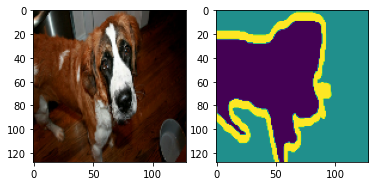

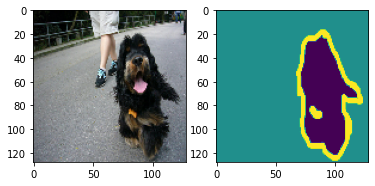

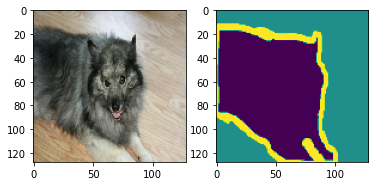

In [46]:
def show_sample(sample_image, sample_mask):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(tf.keras.utils.array_to_img(sample_image))
    ax[1].imshow(tf.keras.utils.array_to_img(sample_mask))

for images, masks in train_loader.take(3):
    sample_image, sample_mask = images[0], masks[0]
    show_sample(sample_image, sample_mask)

In [47]:
def conv_block(inputs, num_filters:int, max_pooling:bool=True, dropout=0):
    x = layers.Conv2D(
        filters=num_filters,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal')(inputs)
    
    x = layers.Conv2D(
        filters=num_filters,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal')(x)
    
    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    if max_pooling:
        next_layer = layers.MaxPooling2D((2,2))(x)
    else:
        next_layer = x
    
    return next_layer, x

In [48]:
def up_block(expansive_input, contractive_input, num_filters:int):
    x = layers.Conv2DTranspose(
        filters=num_filters,
        kernel_size=3,
        strides=(2,2),
        padding='same')(expansive_input)
    
    x = layers.concatenate([x, contractive_input], axis=3)
    
    x = layers.Conv2D(
        filters=num_filters,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal')(x)
    
    x = layers.Conv2D(
        filters=num_filters,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal')(x)
    
    return x

In [49]:
def unet_model(input_shape, num_filters, num_classes):
    inputs = layers.Input(input_shape)
    conv_block_1 = conv_block(inputs, num_filters, max_pooling=True)
    conv_block_2 = conv_block(conv_block_1[0], num_filters * 2, max_pooling=True)
    conv_block_3 = conv_block(conv_block_2[0], num_filters * 4, max_pooling=True)
    conv_block_4 = conv_block(conv_block_3[0], num_filters * 8, dropout=0.3, max_pooling=True)
    conv_block_5 = conv_block(conv_block_4[0], num_filters * 16, dropout=0.3, max_pooling=None)
    
    up_block_6 = up_block(conv_block_5[0], conv_block_4[1], num_filters * 8)
    up_block_7 = up_block(up_block_6, conv_block_3[1], num_filters * 4)
    up_block_8 = up_block(up_block_7, conv_block_2[1], num_filters * 2)
    up_block_9 = up_block(up_block_8, conv_block_1[1], num_filters)
    
    x = layers.Conv2D(
        filters=num_filters,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal')(up_block_9)
    x = layers.Conv2D(
        filters=num_classes,
        kernel_size=1,
        padding='same')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [50]:
model = unet_model(input_shape=(128, 128, 3), num_filters=32, num_classes=3)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 128, 128, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_40[0][0]']              
                                )                                                           

                                                                                                  
 conv2d_58 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_57[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_59 (Conv2D)             (None, 128, 128, 3)  99          ['conv2d_58[0][0]']              
                                                                                                  
Total params: 8,639,811
Trainable params: 8,639,811
Non-trainable params: 0
__________________________________________________________________________________________________


In [51]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [52]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

EPOCHS = 1
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = info.splits['train'].num_examples//BATCH_SIZE

VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

train_dataset = train_ds.cache().shuffle(1000).batch(BATCH_SIZE)
test_dataset = test_ds.cache().batch(BATCH_SIZE)

model_history = model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset)

115/115 [==============================] - 23s 181ms/step - loss: nan - accuracy: 0.0027 - val_loss: nan - val_accuracy: 0.0000e+00


TODO: Train on cloud platform

1/1 [==============================] - 0s 182ms/step


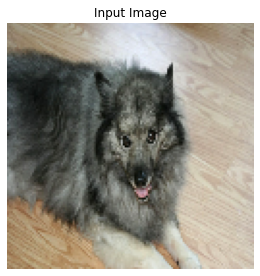

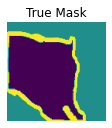

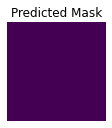

In [53]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
        plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
        
show_predictions()